In [2]:
import ot
import numpy as np
import time

import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm

from data_gen import *
from NN_map import *

In [3]:
def nn_estimation_rate(sampling_function,mapfnt,Ns,Ds,data,numTrials=10,N_sampling=10000,title=None):  
    L2_NN_Error = np.zeros( (len(Ds), len(Ns), numTrials))
    tstart = time.time()
    for k, d in enumerate(Ds):
        for i, n in enumerate(Ns):
            for t in range(numTrials):
                
                ### generate ``training" data 
                source = sampling_function(n,d)
                source_ = sampling_function(n,d)
                target = mapfnt(source_)
                
                ### generate "L^2(P) estimation data"
                source_mc  = sampling_function(N_sampling,d)
                ot_t = mapfnt(source_mc)

                G0 = OT_0(source,target)
                tnn = NNEstimator(source_mc,source,target,G0)

                L2_NN_Error[k,i,t] = (np.linalg.norm( (tnn - ot_t),axis=1)**2).mean()

                if (t+1)%numTrials == 0:
                    print('d=%f, n=%d, trials: %d/%d, time=%d'%(d, n,t+1, numTrials, time.time()-tstart))
        print('==== Done %f d level ===='%(d))

    dict_data = {'Ds': Ds,
                 'N_sampling': N_sampling,
                 'Ns': Ns,
                 'numTrials': numTrials,
                 'L2_NN_Error': L2_NN_Error,
                 'data': data}

    pkl_title = 'CPU-{}_error.pkl'.format(data)
    output = open(pkl_title,'wb')
    pickle.dump(dict_data,output)
    output.close()
    
def CreatePlot_CPU_Errors(file,save=False):
    with open(file, 'rb') as f:
        file1 = pickle.load(f)

    l2_nn = file1['L2_NN_Error']

    Ds = file1['Ds']
    Ns = file1['Ns']
    data = file1['data']
    
    plt.figure(figsize=([6,5]))
    cz = ['r', 'b', 'g']
    print('Estimation rates for 1NN estimator')
    print('Note: theoretical rate is (-2/d)')
    for i,d in enumerate(Ds):

        c = cz[i]
        l2nn_d = l2_nn[i]

        ynn_means = np.mean(l2nn_d,axis=-1)
        ynn_std = np.std(l2nn_d,axis=-1)

        x_ = sm.add_constant(np.log(np.array(Ns)))
        modelnn = sm.OLS(np.log(ynn_means), x_).fit()
        print('d={}, rate={}'.format(d,modelnn.params[1]))

        plt.loglog(Ns,ynn_means,label='d={}'.format(d),c=c)
        plt.errorbar(Ns,ynn_means,yerr=ynn_std,c=c)

    plt.legend()
    plt.xlabel('$n$ samples')
    plt.ylabel('Mean Squared Error')
    if save == True:
        plt.savefig('cpu_error_comp_{}.pdf'.format(data))
    else:
        plt.show()

In [4]:
### Example 1
### P = Unif(-1,1)^d
### T_0(x) = exp(x) coordinate-wise

Ds = [2,5,10]
Ns = [100, 500, 1000, 1500, 2000, 2500]
data = 'unif_exp'

nn_estimation_rate(sample_uniform,OT_exp,Ns,Ds,data=data)

d=2.000000, n=100, trials: 10/10, time=0
d=2.000000, n=500, trials: 10/10, time=2
d=2.000000, n=1000, trials: 10/10, time=8
d=2.000000, n=1500, trials: 10/10, time=22
d=2.000000, n=2000, trials: 10/10, time=44
d=2.000000, n=2500, trials: 10/10, time=77
==== Done 2.000000 d level ====
d=5.000000, n=100, trials: 10/10, time=77
d=5.000000, n=500, trials: 10/10, time=79
d=5.000000, n=1000, trials: 10/10, time=85
d=5.000000, n=1500, trials: 10/10, time=98
d=5.000000, n=2000, trials: 10/10, time=123
d=5.000000, n=2500, trials: 10/10, time=160
==== Done 5.000000 d level ====
d=10.000000, n=100, trials: 10/10, time=161
d=10.000000, n=500, trials: 10/10, time=163
d=10.000000, n=1000, trials: 10/10, time=170
d=10.000000, n=1500, trials: 10/10, time=185
d=10.000000, n=2000, trials: 10/10, time=211
d=10.000000, n=2500, trials: 10/10, time=250
==== Done 10.000000 d level ====


Estimation rates for 1NN estimator
Note: theoretical rate is (-2/d)
d=2, rate=-0.8588697913372276
d=5, rate=-0.4190826947987557
d=10, rate=-0.2104679751584282


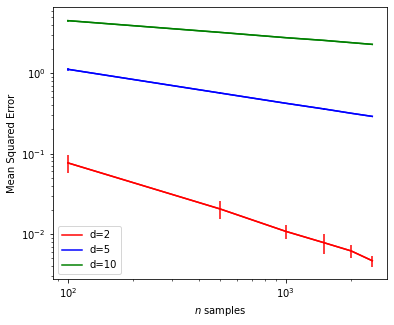

In [5]:
CreatePlot_CPU_Errors('CPU-unif_exp_error.pkl')